# House price prediction

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. The data set is made available by kaggle. 

Some of the attributes that are captured in the dataset are

No of bedrooms and bathrooms

Total square feet of living

How many floors

Wether it has a basement and size of the basement

Grade of the house

Weather it has waterfront and the quality of the view

When the house was built and if the house is renovated, if it is renovated?

Latitude and longitude

price of the house

When the house was sold

# We can do the following analysis using the library

# Exploratory Analysis

Plot a distribution and box plot for the price variable. 

Find out if there are any outliers and list them.

Find out which variables are highly correlated with 'price'.

Find out which zip codes have the highest median house 'price'. Do a bar plot to depict the top 10.

Find out if there are any missing values in the dataset and your strategy for imputing those.

Do some variables need feature engineering or transformation, if they need to be used to predict prices. Explain what transformations you will apply.

# Model Building

Build a regression model to predict the prices

# Evaluation

Calculate the RMSE and R-Squared value on the test data set.

# Models Comparison

Build the following models and find the best performing model with lowest RMSE value.

Decision Tree

Random Forest

# Load the data set

In [1]:
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

In [2]:
sc = SparkContext()

In [3]:
sc.version

u'2.2.0.cloudera2'

In [4]:
spark = SparkSession(sc)

In [5]:
sqlContext = SQLContext(sc)

In [6]:
from pyspark.sql import HiveContext
hiveContext = HiveContext(sc)

In [7]:
housing_df = sqlContext.read.load('/user/gl_faculty_greatlearning/kc3_house_data.csv', 
                          delimiter=',',
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

How many records in the dataset?

In [8]:
housing_df.count()

21613

In [9]:
housing_df.cache()

DataFrame[_c0: int, id: bigint, date: timestamp, price: double, bedrooms: int, bathrooms: double, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int]

In [10]:
housing_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



Exploratory data analysis

Summary Statistics of price and sqft_living

In [11]:
housing_df.describe("price", "sqft_living").show()

+-------+------------------+------------------+
|summary|             price|       sqft_living|
+-------+------------------+------------------+
|  count|             21613|             21613|
|   mean| 540182.1587933188|2079.8997362698374|
| stddev|367362.23171800876| 918.4408970468096|
|    min|           75000.0|               290|
|    max|         7700000.0|             13540|
+-------+------------------+------------------+



We can also explicitly ask for specific stats about columns by passing appropriate stats functions

In [12]:
from pyspark.sql.functions import mean, min, max

In [13]:
housing_df.select([max('price'), mean('price'), min('price')] ).show()

+----------+-----------------+----------+
|max(price)|       avg(price)|min(price)|
+----------+-----------------+----------+
| 7700000.0|540182.1587933188|   75000.0|
+----------+-----------------+----------+



In [14]:
housing_df.select([mean('price'), mean('sqft_living')] ).show()

+-----------------+------------------+
|       avg(price)|  avg(sqft_living)|
+-----------------+------------------+
|540182.1587933188|2079.8997362698374|
+-----------------+------------------+



Is there any relationship between waterfront and view?

In [15]:
bed_bath_df = housing_df.select(['waterfront', 'view'] )

Use crosstab function

In [16]:
bed_bath_df.stat.crosstab("view", "waterfront").show()

+---------------+-----+---+
|view_waterfront|    0|  1|
+---------------+-----+---+
|              0|19489|  0|
|              1|  331|  1|
|              2|  955|  8|
|              3|  491| 19|
|              4|  184|135|
+---------------+-----+---+



Mean and standard deviation of prices for houses by different conditions

In [17]:
from pyspark.sql.functions import avg, stddev

In [18]:
price_conditon_avg_df = housing_df.groupBy('condition').agg(avg('price'))

In [19]:
price_conditon_avg_df.show()

+---------+------------------+
|condition|        avg(price)|
+---------+------------------+
|        1| 334431.6666666667|
|        3| 542097.0860238044|
|        5| 612577.7425044092|
|        4|521300.70522979397|
|        2| 327316.2151162791|
+---------+------------------+



In [20]:
housing_df.groupBy('condition').agg(stddev('price')).show()

+---------+------------------+
|condition|stddev_samp(price)|
+---------+------------------+
|        1|271172.80483730906|
|        3|  364661.792840074|
|        5| 411317.8598148183|
|        4|358768.81104381685|
|        2|245683.98096250606|
+---------+------------------+



# Plotting distribution of price

In [21]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [22]:
housing_price_pd = housing_df.select('price').toPandas()

Density Plot

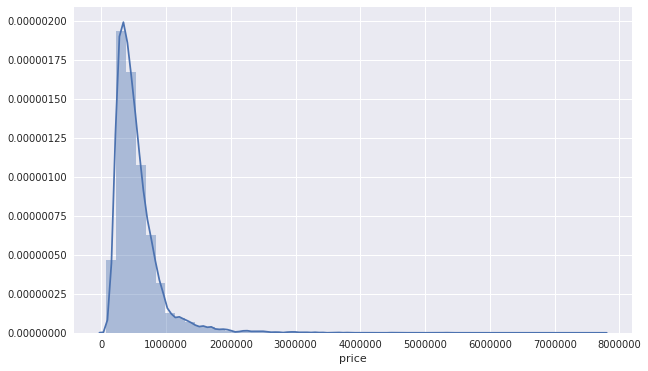

In [23]:
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(housing_price_pd['price'], norm_hist=True)

Box plot

/usr/local/anaconda/python2/lib/python2.7/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


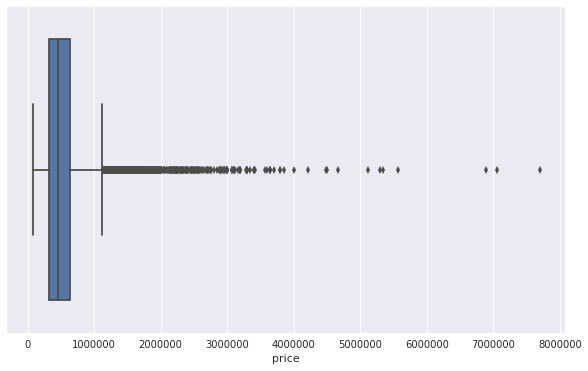

In [24]:
sn.boxplot(x= housing_price_pd['price'])

Observation: We can observe there are many outliers in the dataset as far as price is concerned

Correlation between price and sqft_living

In [25]:
column_labels = ['price','sqft_living', 'sqft_lot', 'bedrooms','bathrooms', \
         'floors', 'sqft_above', 'sqft_basement','yr_built','yr_renovated', \
        'sqft_living15', 'sqft_lot15']

In [26]:
housing_df.stat.corr( 'price', 'sqft_living' )

0.7020437212325301

Observation: sqft_living is highly correated with price

# Which factors are hightly correlated with price

In [27]:
import numpy as np
from pyspark.mllib.stat import Statistics

In [28]:
column_corr = Statistics.corr(housing_df.rdd.map(lambda x:
                         np.array([x['price'],
                                   x['sqft_living'],
                                   x['sqft_lot'],
                                   x['bedrooms'],
                                   x['bathrooms'],
                                   x['floors'],
                                   x['sqft_above'],
                                   x['sqft_basement'],
                                   x['yr_built'],
                                   x['yr_renovated'],
                                   x['sqft_living15'],
                                   x['sqft_lot15']
                                  ])), method='pearson')

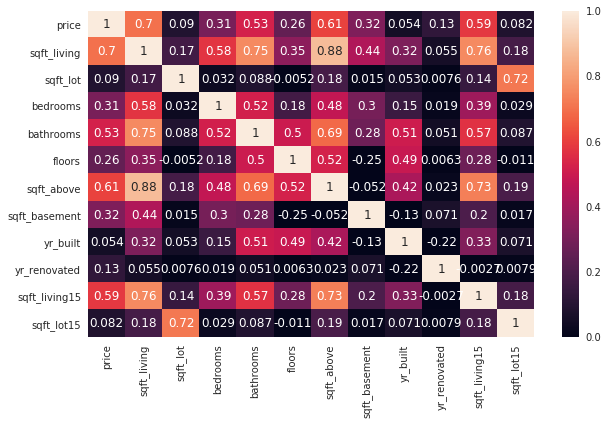

In [29]:
sn.heatmap( column_corr, vmin=0,
          vmax=1,
          annot= True,
          xticklabels = column_labels,
          yticklabels = column_labels )

Observation: The factors sqft_living, number of bathrooms, sqft_living15 and sqft_above seem to be highly correlated with price and can be good predictors for price

# Which zipcodes have high median prices

In [30]:
from pyspark.sql.functions import desc

price_by_zipcodes_df = housing_df.groupBy('zipcode').agg(avg('price')).sort( desc( 'avg(price)') )

In [31]:
price_by_zipcodes_df.toPandas()[0:10]

,zipcode,avg(price)
0,98039,2.161300e+06
1,98004,1.356524e+06
2,98040,1.194874e+06
3,98112,1.096239e+06
4,98102,9.015162e+05
5,98109,8.800778e+05
6,98105,8.632289e+05
7,98006,8.599386e+05
8,98119,8.497148e+05
9,98005,8.102897e+05


Plot top10 zipcodes by price

In [32]:
top_10_zipcodes = price_by_zipcodes_df.toPandas()[0:10]

/usr/local/anaconda/python2/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


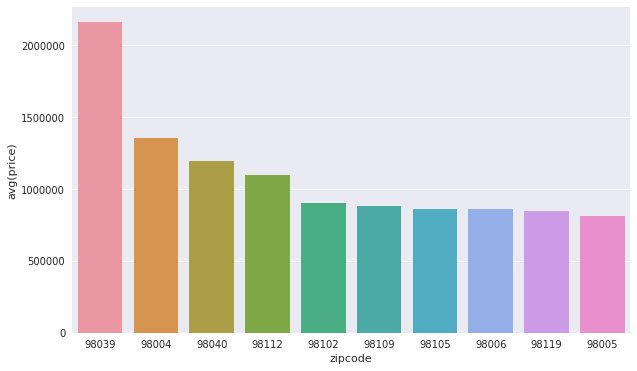

In [33]:
sn.barplot( data = top_10_zipcodes,
          x='zipcode',
          y='avg(price)',
          order = top_10_zipcodes.zipcode)

In [ ]:
Any null values are there

Any null values are there

In [34]:
from pyspark.sql.functions import isnull

house_df_clean = housing_df.na.drop( how = 'any' )

In [35]:
house_df_clean.count() == housing_df.count()

True

# Feature Engineering

Log transformation for price variable

price variable is right skewed. We can apply log transformation to make it normally distributed

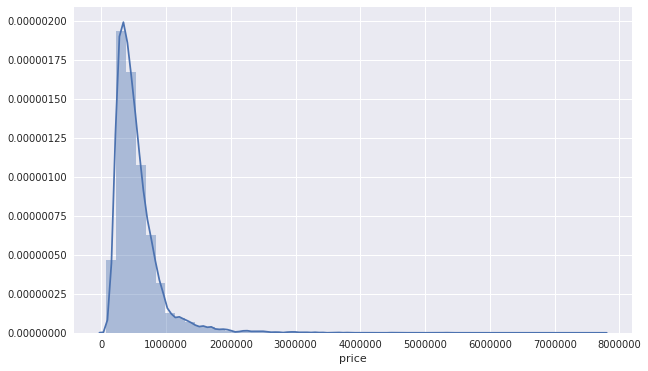

In [36]:
#sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(housing_price_pd['price'], norm_hist=True)

In [37]:
from pyspark.sql.functions import col, log
import seaborn as sn
housing_df = housing_df.withColumn( 'log_price', log('price') )

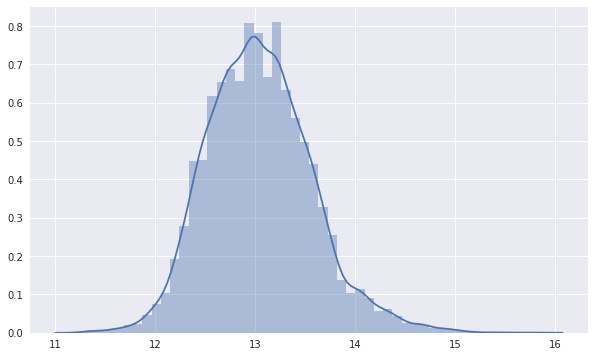

In [38]:
sn.set(rc={"figure.figsize": (10, 6)})
sn.distplot(housing_df.select('log_price').toPandas(), norm_hist=True)

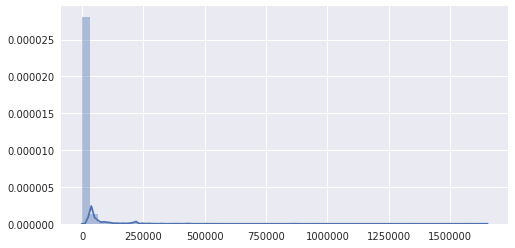

In [39]:
sn.set(rc={"figure.figsize": (8, 4)})
sn.distplot(housing_df.select('sqft_lot').toPandas(), norm_hist=True)

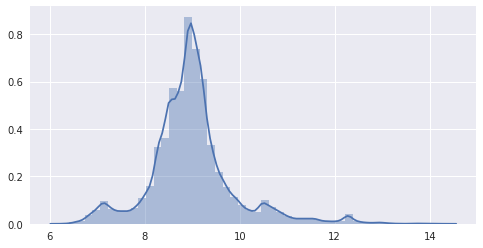

In [40]:
housing_df = housing_df.withColumn( 'log_sqft_lot', log('sqft_lot') )
sn.distplot(housing_df.select('log_sqft_lot').toPandas(), norm_hist=True)

Log transformation for sqft_living variable

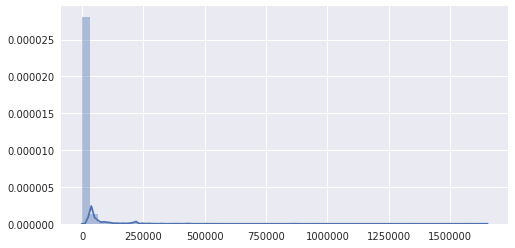

In [41]:
sn.set(rc={"figure.figsize": (8, 4)})
sn.distplot(housing_df.select('sqft_lot').toPandas(), norm_hist=True)

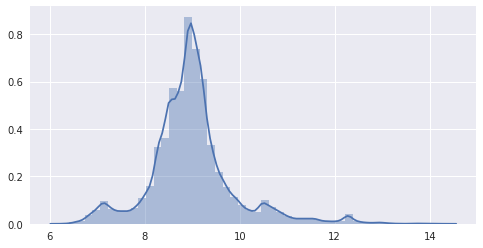

In [42]:
housing_df = housing_df.withColumn( 'log_sqft_lot', log('sqft_lot') )
sn.distplot(housing_df.select('log_sqft_lot').toPandas(), norm_hist=True)

Correlating log transformed of price and sqft_living

In [43]:
housing_df.stat.corr( 'price', 'sqft_lot' )

0.08965520771082404

In [44]:
housing_df.stat.corr( 'log_price', 'log_sqft_lot' )

0.13774619420244752

# Calculating age of the house

In [45]:
from pyspark.sql.functions import lit

housing_df = housing_df.withColumn("age", lit(2018) - col('yr_built'))

In [46]:
housing_df.show( 2 )

+---+----------+-------------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+------------------+--------+-------------+----------+------------------+-----------------+---+
|_c0|        id|               date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|               lat|    long|sqft_living15|sqft_lot15|         log_price|     log_sqft_lot|age|
+---+----------+-------------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+------------------+--------+-------------+----------+------------------+-----------------+---+
|  0|7129300520|2014-10-13 00:00:00|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178

In [47]:
housing_df.columns

['_c0',
 'id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'log_price',
 'log_sqft_lot',
 'age']

When was the house last rennovated?

In [48]:
housing_df = housing_df.withColumn("rennovate_age", lit(2018) - col('yr_renovated'))

In [49]:
housing_df.show(2)

+---+----------+-------------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+------------------+--------+-------------+----------+------------------+-----------------+---+-------------+
|_c0|        id|               date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|               lat|    long|sqft_living15|sqft_lot15|         log_price|     log_sqft_lot|age|rennovate_age|
+---+----------+-------------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+------------------+--------+-------------+----------+------------------+-----------------+---+-------------+
|  0|7129300520|2014-10-13 00:00:00|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180| 

Keep a copy of the original dataframe for later use

In [50]:
housing_original_df = housing_df

In [51]:
from pyspark.sql.functions import round

housing_df = housing_df.withColumn( "label", round('log_price', 4) )

Columns that will be used as features and their types

In [52]:
continuous_features = ['sqft_living', 'bedrooms', 'bathrooms', 'floors',
                    'log_sqft_lot', 'age', 'sqft_above',
                    'sqft_living15', 'sqft_lot15', 'rennovate_age']

categorical_features = ['zipcode', 'waterfront',
                      'grade', 'condition',
                      'view']

Define a function to create categorical features

In [53]:
#def create_category_vars( dataset, field_name ):
 #   idx_col = field_name + "Index"
  #  col_vec = field_name + "Vec"
   # month_stringIndexer = StringIndexer( inputCol=field_name, outputCol=idx_col )
    #month_model = month_stringIndexer.fit( dataset )
    #month_indexed = month_model.transform( dataset )
    #month_encoder = OneHotEncoder( dropLast=True, inputCol=idx_col, outputCol= col_vec )
    
    #return month_encoder.transform( month_indexed )

Encoding all categorical features

In [54]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer
stages = []
#for col in categorical_features:
 #   housing_df = create_category_vars( housing_df, col )
    
for col in categorical_features:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index')
    encoder = OneHotEncoder(inputCol=col + 'Index', outputCol=col + "Vec")
    stages += [stringIndexer, encoder]

#housing_df.cache()

In [55]:
stages

[StringIndexer_4dc98eecc24dbd8c80ff,
 OneHotEncoder_4f3bb66b1ae3fa066fe4,
 StringIndexer_428ebd0c99fdab51437b,
 OneHotEncoder_49308f3cf5496ad9dbd7,
 StringIndexer_4cb69235cd630103142c,
 OneHotEncoder_41f6bbfa0b7334224fa8,
 StringIndexer_499789d2c8333d1e91ca,
 OneHotEncoder_442b9502d13ccce9f15e,
 StringIndexer_4c0180f662171f0d28ca,
 OneHotEncoder_4e7e974bb8ef2dfa8f8b]

Create vectors from all features column

In [56]:
featureCols = continuous_features + ['zipcodeVec',
                                   'waterfrontVec',
                                   'gradeVec',
                                   'conditionVec',
                                   'viewVec']

In [57]:
featureCols

['sqft_living',
 'bedrooms',
 'bathrooms',
 'floors',
 'log_sqft_lot',
 'age',
 'sqft_above',
 'sqft_living15',
 'sqft_lot15',
 'rennovate_age',
 'zipcodeVec',
 'waterfrontVec',
 'gradeVec',
 'conditionVec',
 'viewVec']

# Getting prepared for model building

The dataframe need to have two columns: features and label
    
The vector columns need to named as features

The target variable need to be named as label

Then the dataframe can be directly fed to a model to learn

In [58]:
assembler = VectorAssembler( inputCols = featureCols, outputCol = "features")

In [59]:
assembler.outputCol

Param(parent=u'VectorAssembler_4415a760fabaf5def31d', name='outputCol', doc='output column name.')

In [60]:
#housing_train_df = assembler.transform( housing_df )
stages += [assembler]

stages

[StringIndexer_4dc98eecc24dbd8c80ff,
 OneHotEncoder_4f3bb66b1ae3fa066fe4,
 StringIndexer_428ebd0c99fdab51437b,
 OneHotEncoder_49308f3cf5496ad9dbd7,
 StringIndexer_4cb69235cd630103142c,
 OneHotEncoder_41f6bbfa0b7334224fa8,
 StringIndexer_499789d2c8333d1e91ca,
 OneHotEncoder_442b9502d13ccce9f15e,
 StringIndexer_4c0180f662171f0d28ca,
 OneHotEncoder_4e7e974bb8ef2dfa8f8b,
 VectorAssembler_4415a760fabaf5def31d]

# Build the Linear Regression Model

In [61]:
#from pyspark.ml.regression import LinearRegression
import pyspark.ml.regression as reg


In [62]:
linreg = reg.LinearRegression(maxIter=500, regParam=0.0)
#linreg = LinearRegression(maxIter=500, regParam=0.0)

In [63]:
stages += [linreg]
stages

[StringIndexer_4dc98eecc24dbd8c80ff,
 OneHotEncoder_4f3bb66b1ae3fa066fe4,
 StringIndexer_428ebd0c99fdab51437b,
 OneHotEncoder_49308f3cf5496ad9dbd7,
 StringIndexer_4cb69235cd630103142c,
 OneHotEncoder_41f6bbfa0b7334224fa8,
 StringIndexer_499789d2c8333d1e91ca,
 OneHotEncoder_442b9502d13ccce9f15e,
 StringIndexer_4c0180f662171f0d28ca,
 OneHotEncoder_4e7e974bb8ef2dfa8f8b,
 VectorAssembler_4415a760fabaf5def31d,
 LinearRegression_41cc91096e5cc4a22dff]

In [64]:
from pyspark.ml import Pipeline

In [65]:
pipeline = Pipeline(stages = stages)

In [66]:
pipeline

Pipeline_4f4bbb7174e5f7278e83

In [67]:
seed = 42
train_df, test_df = housing_df.randomSplit( [0.7, 0.3], seed = seed )

In [68]:
model = pipeline.fit(train_df)


In [69]:
test_model = model.transform(test_df)

In [70]:
test_model.show(5)

+---+----------+-------------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+------------------+-------------------+-------------+----------+------------------+-----------------+---+-------------+-------+------------+---------------+---------------+-------------+----------+--------------+--------------+-------------+---------+-------------+--------------------+------------------+
|_c0|        id|               date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|               lat|               long|sqft_living15|sqft_lot15|         log_price|     log_sqft_lot|age|rennovate_age|  label|zipcodeIndex|     zipcodeVec|waterfrontIndex|waterfrontVec|gradeIndex|      gradeVec|conditionIndex| conditionVec|viewIndex|      viewVec|            features|        prediction|
+---+----------+--------------

In [75]:
#lm = linreg.fit( train_df )

In [76]:
#lm.intercept

12.66312958458747

In [77]:
#lm.coefficients

DenseVector([0.0001, -0.0032, 0.0452, -0.0126, 0.0632, 0.0003, 0.0001, 0.0001, -0.0, -0.0, -0.3671, -1.0495, -0.3662, -0.5869, -0.3755, -1.1627, -0.6853, -0.743, -1.2461, -0.5937, -0.75, -0.8895, -1.0629, -0.7928, -0.6744, -0.4314, -0.7051, -0.6442, -0.8913, -0.6449, -1.2223, -0.6866, -0.6513, -1.2038, -0.5099, -0.8399, -0.4381, -0.6, -0.3287, -0.1304, -0.8164, -0.389, -0.9275, -0.5645, -0.8071, -0.3599, -1.207, -1.17, -1.1463, -0.7535, -0.1472, -1.1279, -1.0726, -0.3432, -0.5252, -1.0442, -1.1639, -0.622, -0.8968, -1.1814, -0.2477, -0.9099, -1.2308, -0.8244, -0.7745, -0.9063, -0.8486, -0.2181, -0.507, -0.5644, -1.1094, -1.2477, -0.9115, -0.9262, -0.1729, -0.2425, -0.9997, -0.844, -1.034, -0.4293, 0.3701, 0.47, 0.5688, 0.2502, 0.6104, 0.6462, 0.104, 0.6769, 0.1656, 0.6611, 0.5743, 0.2464, 0.2892, 0.3596, 0.1302, -0.2655, -0.1598, -0.1055, -0.1609])

# Make predictions on test data and evaluate

In [71]:
test_model.select( 'features', 'label', 'prediction' ).show( 5 )

+--------------------+-------+------------------+
|            features|  label|        prediction|
+--------------------+-------+------------------+
|(99,[0,1,2,3,4,5,...|13.1956|13.181938301506854|
|(99,[0,1,2,3,4,5,...|12.1007| 12.57924121365834|
|(99,[0,1,2,3,4,5,...|13.3113|13.181639092911304|
|(99,[0,1,2,3,4,5,...|12.8992|12.899832588036503|
|(99,[0,1,2,3,4,5,...|12.8866|12.783060974735694|
+--------------------+-------+------------------+
only showing top 5 rows



In [72]:
y_pred = test_model

Calculate the actual predicted price

In [73]:
from pyspark.sql.functions import exp

y_pred = y_pred.withColumn( "y_pred", exp( 'prediction' ) )

Calculate RMSE

In [74]:
from pyspark.ml.evaluation import RegressionEvaluator

In [75]:
rmse_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="rmse" )

In [76]:
lm_rmse = rmse_evaluator.evaluate( y_pred )

In [77]:
lm_rmse

135702.71365440032

Calculate R-squared

In [78]:
r2_evaluator = RegressionEvaluator(labelCol="price",
                              predictionCol="y_pred",
                              metricName="r2" )

In [79]:
lm_r2 = r2_evaluator.evaluate( y_pred )

In [80]:
lm_r2

0.8609376200480646